In [101]:
import numpy as np
from scipy.linalg import block_diag
from scipy.linalg import expm
from scipy.integrate import solve_ivp
def build_system_with_weight_input(masses_nodes, masses_drones, k, c, kd, drone_nodes,graph_matrix, g=9.81):
    n_nodes = len(masses_nodes)
    n_drones = len(masses_drones)
    dim_x = 2 * (n_nodes + n_drones)
    
    A = np.zeros((dim_x, dim_x))
    B = np.zeros((dim_x, 3 + n_nodes + n_drones))  # 3 droni + 4 nodi + 3 droni pesi
    
    # Derivata posizione = velocità
    A[0:n_nodes, n_nodes:2*n_nodes] = np.eye(n_nodes)
    A[2*n_nodes:2*n_nodes + n_drones, 2*n_nodes + n_drones:dim_x] = np.eye(n_drones)
    
    # Forze tra nodi (grafo arbitrario)
    for i in range(n_nodes):
        row = n_nodes + i
        for j in range(n_nodes):
            if i == j:
                continue
            if graph_matrix[i,j]: #se connessi (se i==j somma e toglie lo stesso)
                A[row, i] += -k / masses_nodes[i]
                A[row, j] += k / masses_nodes[i]
                A[row, n_nodes + i] += -c / masses_nodes[i]
                A[row, n_nodes + j] += c / masses_nodes[i]
    
    # Molle drone-nodo
    for i in range(n_drones):
        node_i = drone_nodes[i]
        drone_pos_idx = 2*n_nodes + i
        drone_vel_idx = 2*n_nodes + n_drones + i
        node_vel_idx = n_nodes + node_i
        node_pos_idx = node_i
        
        A[node_vel_idx, node_pos_idx] += -kd / masses_nodes[node_i]
        A[node_vel_idx, drone_pos_idx] += kd / masses_nodes[node_i]
        
        A[drone_vel_idx, node_pos_idx] += kd / masses_drones[i]
        A[drone_vel_idx, drone_pos_idx] += -kd / masses_drones[i]
    
    # Input forze sui droni (3 colonne)
    for i in range(n_drones):
        drone_acc_row = 2*n_nodes + n_drones + i
        B[drone_acc_row, i] = 1 / masses_drones[i]
    
    # Input peso nodi (colonne 3 a 3+n_nodes-1)
    for i in range(n_nodes):
        node_acc_row = n_nodes + i
        col_idx = 3 + i
        B[node_acc_row, col_idx] = -1  # forza peso.
    
    # Input peso droni (colonne 3+n_nodes a 3+n_nodes+n_drones-1)
    for i in range(n_drones):
        drone_acc_row = 2*n_nodes + n_drones + i
        col_idx = 3 + n_nodes + i
        B[drone_acc_row, col_idx] = -1
    
    return A, B


In [102]:
def build_system_with_drones(masses_nodes, masses_drones, k, c, kd, drone_nodes, graph_matrix):
    """
    masses_nodes: liste masse 4 nodi
    masses_drones: liste masse 3 droni
    k, c: costante molla e smorzamento grafo completo nodi
    kd: costante molla drone-nodo
    drone_nodes: lista indici nodi a cui sono collegati i droni (len=3) drone i è collegato  a drone_nodes[i]
    graph_matrix: matrice di adiacenza delle molle(n_nodes x n_nodes)

    Restituisce A (14x14), B (14x3)
    Stato: [pos nodi(4), vel nodi(4), pos droni(3), vel droni(3)]
    Input: forze applicate ai droni (3 input)
    """
    n_nodes = len(masses_nodes)
    n_drones = len(masses_drones)
    dim_x = 2*(n_nodes + n_drones)  # 8 + 6 = 14
    
    m_nodes = masses_nodes
    m_drones = masses_drones
    
    A = np.zeros((dim_x, dim_x))
    B = np.zeros((dim_x, n_drones))
    
    # Pos nodi -> vel nodi
    A[0:n_nodes, n_nodes:2*n_nodes] = np.eye(n_nodes) #A is organized first nodes position and nodes velocity and then drones position and drones velocities
    # Pos droni -> vel droni
    A[2*n_nodes:2*n_nodes + n_drones, 2*n_nodes + n_drones:dim_x] = np.eye(n_drones)
    
    # Forze molle-smorzatori tra nodi (arbitrary graph)
    for i in range(n_nodes):
        row = n_nodes + i  # equazione accelerazione nodo i
        
        for j in range(n_nodes):
            if j == i:
                continue
            # Forza elastica tra nodi i,j
            if(graph_matrix[i,j]): #if they are connected
                A[row, i] += -k / m_nodes[i] #k(xj-xi)
                A[row, j] += k / m_nodes[i]
            # Forza smorzante tra nodi i,j
                A[row, n_nodes + i] += -c / m_nodes[i] # c(xj'-xi')
                A[row, n_nodes + j] += c / m_nodes[i]
    
    # Forze drone-nodo (molle kd)
    # Nodo i è drone_nodes[i], drone i
    for i in range(n_drones):
        node_i = drone_nodes[i]
        drone_pos_idx = 2*n_nodes + i #skippa oltre i nodi
        drone_vel_idx = 2*n_nodes + n_drones + i #arriva alle velocità
        node_vel_idx = n_nodes + node_i
        node_pos_idx = node_i
        
        # Nodo: forza dalla molla col drone
        # F = -kd (x_node - x_drone)
        A[node_vel_idx, node_pos_idx] += -kd / m_nodes[node_i]
        A[node_vel_idx, drone_pos_idx] += kd / m_nodes[node_i]
        
        # Drone: forza uguale e opposta
        A[drone_vel_idx, node_pos_idx] += kd / m_drones[i]
        A[drone_vel_idx, drone_pos_idx] += -kd / m_drones[i]
    
    # Input forze applicate ai droni (sulle accelerazioni droni)
    for i in range(n_drones):
        drone_acc_row = 2*n_nodes + n_drones + i
        B[drone_acc_row, i] = 1 / m_drones[i]
    
    return A, B





In [103]:
n_nodes=4
n_drones=3
m_node=1
m_drone=0.5
masses_nodes = np.ones(n_nodes)*m_node
masses_drones = np.ones(n_drones)*m_drone
k = 100.0
c = 5
kd = 200.0
drone_nodes = [1, 2, 3]
graph=np.ones((n_nodes,n_nodes))
X, L = build_system_with_drones(masses_nodes, masses_drones, k, c, kd, drone_nodes,graph_matrix=graph) # sulle x
L=np.concat((L,np.zeros((14,13))),axis=1)
Y, C = build_system_with_drones(masses_nodes, masses_drones, k, c, kd, drone_nodes,graph_matrix=graph) # sulle y
C=np.concat((np.zeros((14,3)),C,np.zeros((14,10))),axis=1)
Z, D = build_system_with_weight_input(masses_nodes, masses_drones, k, c, kd, drone_nodes,graph_matrix=graph) #sulle z
D=np.concatenate((np.zeros((14,6)),D),axis=1)

In [104]:
#building the whole system
A=block_diag(X,Y,Z)
B=np.concat((L,C,D),axis=0)#the input are the union of the input (3 on x and y and 10 on z ,last 7 are gravity)

In [ ]:
#simulating the system evolution with a set of initial conditions:
n=n_nodes+n_drones
x0=np.zeros(6*n)
l=1
def generate_nodes(n_rings,radius,points_per_ring):
        nodes = []
        nodes.append(np.array([0, 0, 0]))  # center point
        for r in range(1,n_rings):
            radius_r = radius * r / (n_rings - 1)
            for i in range(points_per_ring):
                angle = 2 * np.pi * i / points_per_ring
                x = radius_r * np.cos(angle)
                y = radius_r * np.sin(angle)
                nodes.append(np.array([x, y, 0]))
        node = np.array(nodes)
        return node 
#node now is (0,0,0; x,y,z; ...)
nodes=generate_nodes(n_rings=2,radius=l,points_per_ring=3) #create triangle
drone_nodes
for i in range(n_nodes):
        x0[i]=nodes[i,0] #x of i node
        x0[i+2*n]=nodes[i,1] #y of i node (z already at zeros)
for i in range(n_drones):
        for j in range(n_nodes): #this needs to be checked 
                if drone_nodes[i]==j:
                        x0[i+2*n_nodes]=x0[j] #x0 of drone i
                        x0[i+2*n+2*n_nodes]=x0[j+2*n] #y_0 of drone i
                        x0[i+4*n+2*n_nodes]=1  #z0 of drone i
#central node is already at 0
g=9.81
weight_nodes=masses_nodes@np.diag(np.ones(n_nodes)*g)
weight_drones=masses_drones@np.diag(np.ones(n_drones)*g)
u=lambda t:np.zeros(16)*t
#u[-n-3:-n]=1 #the three drone push toward z
#u[-n:-n+n_nodes]=weight_nodes
#u[-n_drones:]=weight_drones
def system_dynamics(A,B,u):
        def dym(t,state):
              derivatives=A@state+B@u(t)
              return derivatives
        return dym
              
motion=system_dynamics(A,B,u)
t_eval=np.linspace(0,10,1000)
x=solve_ivp(motion,[0,10],x0,t_eval=t_eval)



In [112]:
node_positions=[(x.y[i,:],x.y[i+n*2,:],x.y[i+4*n,:]) for i in range(n_nodes)] 


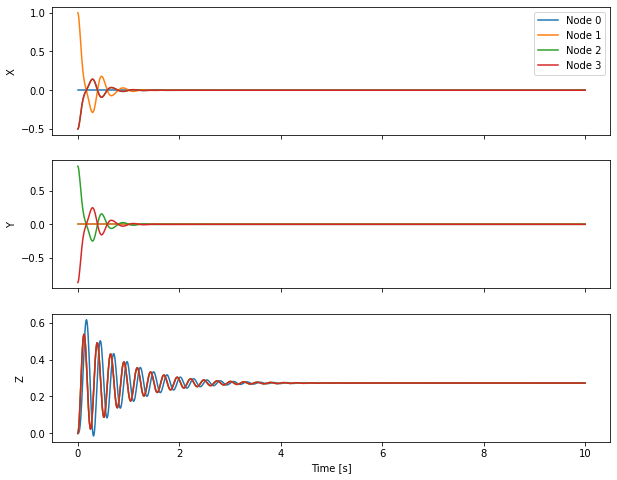

In [114]:
import matplotlib.pyplot as plt

node_positions_array = np.array(node_positions)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i in range(n_nodes):
    axs[0].plot(t_eval, node_positions_array[i, 0, :], label=f"Node {i}")
    axs[1].plot(t_eval, node_positions_array[i, 1, :])
    axs[2].plot(t_eval, node_positions_array[i, 2, :])

axs[0].set_ylabel("X")
axs[1].set_ylabel("Y")
axs[2].set_ylabel("Z")
axs[2].set_xlabel("Time [s]")
axs[0].legend()
plt.show()